In [11]:
import joblib
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from matplotlib.patches import Patch
import torch as th

DATASET_NAME = 'CIC_IDS_2017'
EXPERIMENT_NAME = 'strat_window'
GRAPH_CONSTRUCTION = 'host'
WINDOW_SIZE = 2000


# Ensure root project path is in sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

from Datasets.CIC_IDS_2017.CIC_IDS_2017_config import CIC_IDS_2017_Config as Database_Config

BENIGN_CLASS_NAME = Database_Config.BENIGN_CLASS_NAME
LABEL_COL_NAME = Database_Config.ATTACK_CLASS_COL_NAME

experiment_saved_path = os.path.join(project_root, "Models/E_GraphSAGE", DATASET_NAME, 'saved', f"{EXPERIMENT_NAME}_{GRAPH_CONSTRUCTION}_{WINDOW_SIZE}")

test_graph_dataset_path = os.path.join(experiment_saved_path, 'test_graph_dataset.pth')
labeller_path = os.path.join(experiment_saved_path, 'labeller.pkl')
class_map_path = os.path.join(experiment_saved_path, 'class_map.pkl')

class_map = joblib.load(class_map_path)
le = joblib.load(labeller_path)


In [12]:
from collections import defaultdict
from typing import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils import class_weight


from tqdm import tqdm

class StratifiedGraphDataset:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.total_count = len(self.y)

        # Compute class weights
        labels = []

        for graph in self.X:
            labels.append(graph.edge_label.tolist())

        labels = np.concatenate(labels)

        self.class_counts = Counter(labels)

        # Compute the class weights
        self.class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(labels),
            y=labels
        )

    def k_fold_split(self, k: int = 5, test_ratio: float = 0.15, random_state: int = 42):
        cv = MultilabelStratifiedShuffleSplit(test_size=test_ratio, random_state=random_state, n_splits=k)

        mlb = MultiLabelBinarizer()

        y_binary = mlb.fit_transform(self.y)

        return cv.split(np.zeros(len(self.X)), y_binary)

    def graph_train_test_split(self, test_ratio: float = 0.15, random_state: int = 42):
        train_idx, test_idx = next(self.k_fold_split(k = 1, test_ratio = test_ratio, random_state = random_state))
        
        X_train = [self.X[i] for i in train_idx]
        X_test = [self.X[i] for i in test_idx]

        y_train = [self.y[i] for i in train_idx]
        y_test = [self.y[i] for i in test_idx]

        return StratifiedGraphDataset(X_train, y_train), StratifiedGraphDataset(X_test, y_test)
    
    def print_class_distribution_and_weights(self):
        # Use the label encoder to inverse transform the class labels
        class_counts_named = {cls: count for cls, count in self.class_counts.items()}
        class_weights_named = {cls: weight for cls, weight in enumerate(self.class_weights)}
        print("Class Counts and Weights:")
        for cls_label in class_counts_named.keys():
            count = class_counts_named[cls_label]
            weight = class_weights_named[cls_label]
            print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}, Weight = {weight:<10.4f}")
    
    def __len__(self):
        return self.total_count

    def __iter__(self):
        for g in self.X:
            yield g
            
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.X[idx], self.y[idx]
        elif isinstance(idx, slice):
            return [self.X[i] for i in range(len(self.X))][idx], [self.y[i] for i in range(len(self.y))][idx]
        else:
            raise TypeError("Index must be an integer or a slice.")

In [13]:
test_graph_dataset = th.load(test_graph_dataset_path, weights_only=False)

BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0]
ADVERSARIAL_CLASS_LABEL = len(class_map)

In [14]:
# Get an example for each lable from the test dataset
def get_example_graphs_by_label(graph_dataset, class_map):
    example_graphs = defaultdict(list)
    
    for graph in graph_dataset:
        graph_labels = graph.edge_label.tolist()
        for label in graph_labels:
            class_name = le.inverse_transform([label])[0]
            example_graphs[class_name].append(graph)
    
    return example_graphs

example_graphs = get_example_graphs_by_label(test_graph_dataset, class_map)

KeyboardInterrupt: 

Number of graphs for class 'DDoS': 20496


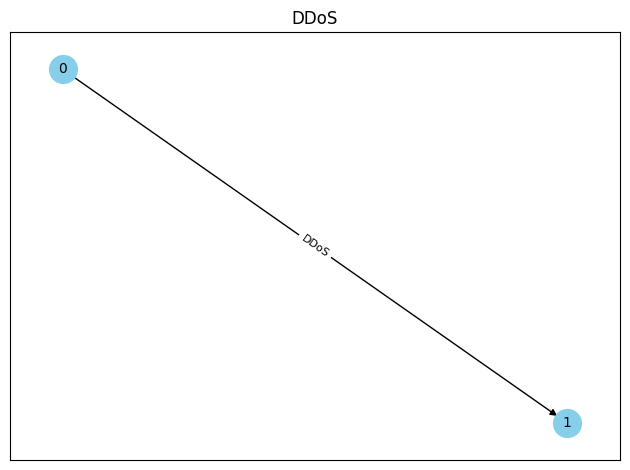

/tmp/ipykernel_3235049/2214569771.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_labels))


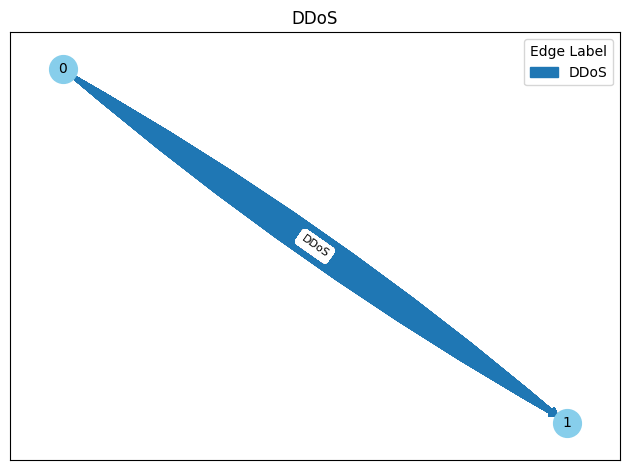

In [15]:
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it

class_name = 'DDoS'
graph_id = 3000

# Ensure the directory exists before saving the file
save_dir = f"graphs/{DATASET_NAME}/{EXPERIMENT_NAME}/{GRAPH_CONSTRUCTION}/{WINDOW_SIZE}/{class_name}"
os.makedirs(save_dir, exist_ok=True)

graphs = example_graphs[class_name]
print(f"Number of graphs for class '{class_name}': {len(graphs)}")
data = graphs[graph_id]


# Convert to MultiDiGraph
G = torch_geometric.utils.to_networkx(data, to_undirected=False, to_multi=True, edge_attrs=['edge_label'])
G_single = torch_geometric.utils.to_networkx(data, to_undirected=False, edge_attrs=['edge_label'])


def draw_labelled_single_edge(G, attr_name, ax=None):
    # Increase k to spread nodes further apart, and increase iterations for stability
    pos = nx.spring_layout(G, seed=42, k=100.0, iterations=500)

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='skyblue', node_size=400)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

    # Get all unique edge labels and convert to class names using le
    edge_labels = {
        (u, v): le.inverse_transform([d[attr_name]])[0]
        for u, v, d in G.edges(data=True)
        if attr_name in d
    }
    
    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)

    plt.title(class_name)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/single_edge_plot_{class_name}_ID_{graph_id}.png")
    plt.show()

def draw_labeled_multigraph(G, attr_name, ax=None):
    # Increase k to spread nodes further apart, and increase iterations for stability
    pos = nx.spring_layout(G, seed=42, k=100.0, iterations=500)

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='skyblue', node_size=400)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

    # Get all unique edge labels and convert to class names using le
    edge_labels = {
        (u, v, k): le.inverse_transform([d[attr_name]])[0]
        for u, v, k, d in G.edges(keys=True, data=True)
        if attr_name in d
    }
    unique_labels = sorted(set(edge_labels.values()))
    color_map = plt.cm.get_cmap('tab10', len(unique_labels))
    label_to_color = {lbl: color_map(i) for i, lbl in enumerate(unique_labels)}

    # Draw edges by label, using different rad values for multi-edges
    for lbl in unique_labels:
        edges = [(u, v, k) for (u, v, k), l in edge_labels.items() if l == lbl]
        # Group edges by (u, v)
        edge_groups = {}
        for (u, v, k) in edges:
            edge_groups.setdefault((u, v), []).append(k)
        for (u, v), keys in edge_groups.items():
            n = len(keys)
            # Assign a unique rad for each multi-edge
            for idx, k in enumerate(keys):
                # Spread rad between -0.7 and 0.7 for up to 7 edges, scale if more
                if n == 1:
                    rad = 0.0
                else:
                    rad = np.linspace(-0.05, 0.05, n)[idx]
                nx.draw_networkx_edges(
                    G, pos, edgelist=[(u, v, k)], ax=ax,
                    edge_color=[label_to_color[lbl]],
                    connectionstyle=f"arc3,rad={rad}"
                )

    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)

    # Add legend for edge colors
    legend_handles = [
        Patch(color=label_to_color[lbl], label=f"{lbl}")
        for lbl in unique_labels
    ]
    if ax is not None:
        ax.legend(handles=legend_handles, title="Edge Label", loc="best")
    else:
        plt.legend(handles=legend_handles, title="Edge Label", loc="best")
    
    plt.title(class_name)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/multi_edge_plot_{class_name}_ID_{graph_id}.png")
    plt.show()

# Draw the graph
draw_labelled_single_edge(G_single, "edge_label", ax=plt.gca())
draw_labeled_multigraph(G, "edge_label", ax=plt.gca())



In [16]:
# Visualize the graph with PyVis
from pyvis.network import Network
from IPython.display import display, HTML
import os

def visualize_graph_with_pyvis(G):
    net = Network(notebook=True, height='600px', width='100%', directed=True)
    # Get all unique edge labels and assign a color to each
    edge_labels = []
    for u, v, k, d in G.edges(keys=True, data=True):
        label = d.get('edge_label', None)
        if label is not None:
            # Convert label to class name using le
            class_label = le.inverse_transform([label])[0]
            edge_labels.append(class_label)
    unique_labels = sorted(set(edge_labels))
    color_map = plt.cm.get_cmap('tab10', len(unique_labels))
    label_to_color = {lbl: f"#{int(255*r):02x}{int(255*g):02x}{int(255*b):02x}" 
                      for lbl, (r, g, b, _) in zip(unique_labels, color_map.colors)}

    # Add nodes without text labels
    for node in G.nodes():
        net.add_node(node, label="")  # No label

    # Add edges with color but no label
    for u, v, k, d in G.edges(keys=True, data=True):
        label = d.get('edge_label', None)
        if label is not None:
            class_label = le.inverse_transform([label])[0]
            color = label_to_color[class_label]
            net.add_edge(u, v, color=color, title=class_label)
        else:
            net.add_edge(u, v)

    net.set_edge_smooth('dynamic')
    net.show_buttons(filter_=['physics'])

    net.show(f"{save_dir}/{class_name}_ID_{graph_id}.html")

    # Show legend for edge colors
    legend_html = "<div style='display:flex;flex-wrap:wrap;'>"
    for lbl in unique_labels:
        color = label_to_color[lbl]
        legend_html += f"<div style='margin-right:20px;display:flex;align-items:center;'><div style='width:20px;height:20px;background:{color};display:inline-block;margin-right:5px;'></div>{lbl}</div>"
    legend_html += "</div>"
    display(HTML(legend_html))

# Visualize the graph
visualize_graph_with_pyvis(G)


/tmp/ipykernel_3235049/401277386.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_labels))


graphs/CIC_IDS_2017/strat_window/host/2000/DDoS/DDoS_ID_3000.html
